# Confidence intervals and statistical tests

Hypothesis testing and confidence intervals are the most basic but also the most powerful concepts of classical statistics. 
In the following we show how these concepts are intelinked and how one should interpret results.

In [1]:
%config IPCompleter.greedy = True

import numpy as np
import pandas as pd
import itertools

from pandas import Series
from pandas import DataFrame

from tqdm import tnrange, tqdm
from plotnine import *

from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import zconfint

from scipy.stats import binom
from scipy.stats import norm

## III. What does the confidence level mean?

The confidence level is a subtle concept. Most importantly, confidence level **is not** a probability that a true parameter value is inside the confidence interval. Confidence level $\alpha$ shows uncertaintly related to the average case behaviour.

If one could repeat the data collection infinite amount of times and compute the confidence interval for each of them then in $\alpha$-fraction of runs the true parameter value is inside the interval.
This does not say anything about the particular run and a confidence interval we are interested in.

To get actionable outcome, we must use ultra-fequentist resolution and state that the true value is inside the interval as events with probability $1-\alpha$ do not happen. 
The latter is slighty silly for $90\%$ and $95\%$ confidence intervals but this is how engineers work.

# Homework  

## 1.1 Comparison of different confidence interval methods (<font color='red'>1p</font>)

The function `proportion_confint` implements six different methods for computing confidence intervals. 
Most of them are approximations. Compare how well these methods work. For that execute the following simulation:
* Sample observations from binomial distribution.
* Compute different confidence intervals for each observation.
* Estimate the fraction of correct guesses for each method and tabulate the results on `geom_col`.
* Show the expected baseline value on each plot or facet.

Try different values of $n\in\{20, 100\}$ and different confidence levels $\alpha\in\{90\%, 99\%\}$. 
Interpret results. Are there any significant differences between different methods. 
You can also visualise the locations of the confidence intervals using `geom_jitter`.

## Solution

**We generated 1000 observations from the binomial distribution $B(n, p = 0.4)$ and for each observation we computed confidence intervals using all available methods in the `proportion_confint` function. We did this for $n \in \{20, 100\}$ and $\alpha \in \{0.1, 0.01\}$ pairs for a total of 4 simulation experiments.**

In [2]:
p = 0.4
N_sims = 1000
n_values = [20, 100]
alpha_values = [0.1, 0.01]
methods = ['normal', 'agresti_coull', 'beta', 'wilson', 'jeffreys', 'binom_test']

intervals = []
for n, alpha in itertools.product(n_values, alpha_values):
    observations = binom.rvs(n = n, p = p, size = N_sims)
    for method in methods:
        intervals.append(DataFrame({'n': n, 'alpha': alpha, 'method': method, 'k': observations, 'y': np.linspace(0, 1, N_sims)})) # y is for plotting the confidence intervals later         
intervals = pd.concat(intervals, ignore_index = True)

# It would be faster to assign q1 and q2 inside the loop with "proportion_confint(observations, nobs = n, alpha = alpha, method = method)" but it did not work for binom_test.
intervals[['q1', 'q2']] = pd.DataFrame(intervals.apply(lambda df: proportion_confint(df['k'], nobs = df['n'], alpha = df['alpha'], method = df['method']), axis = 1).tolist(), index = intervals.index)
intervals['is_fail'] = (p <= intervals.q1) | (p >= intervals.q2)
intervals['is_correct'] = ~intervals.is_fail

**For each experiment and method, we found and visualised the fraction of intervals that successfully covered the true parameter $p$ value.**

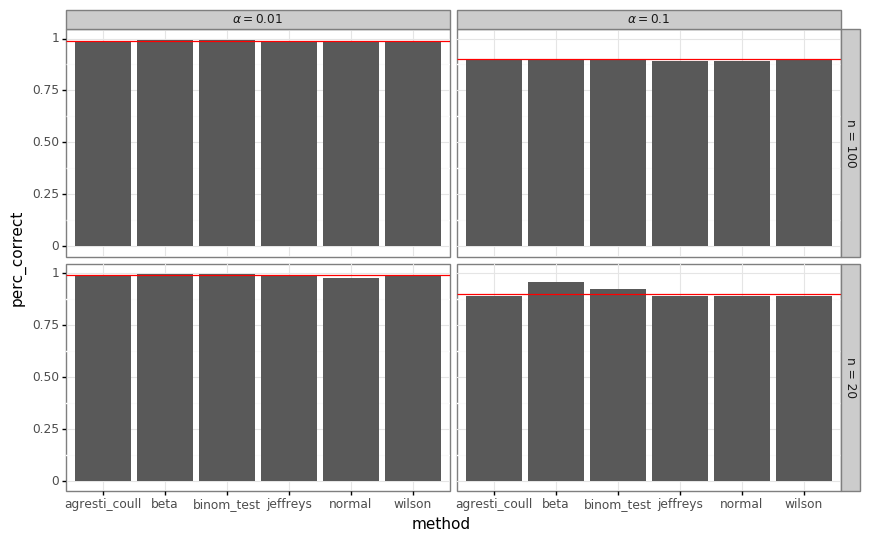

<ggplot: (7540734447)>

In [3]:
successes = intervals.groupby(['method', 'alpha', 'n'])['is_correct'] \
    .aggregate([('perc_correct', 'mean')]) \
    .reset_index() \
    .assign(confidence = lambda df: 1 - df['alpha'])
successes['alpha_label'] = successes.apply(lambda df: r'$\alpha = {}$'.format(df['alpha']), axis = 1)
successes['n_label'] = successes.apply(lambda df: r'n = {}'.format(df['n']), axis = 1)

ggplot(successes, aes(x = 'method', y = 'perc_correct')) + \
    geom_col() + \
    theme_bw() + \
    theme(figure_size = (10, 6)) + \
    geom_hline(aes(yintercept = 'confidence'), colour = 'red') + \
    facet_grid(['n_label', 'alpha_label'])

**All the methods seem to achieve average coverage close to $1 - \alpha$, though we can see that for smaller $n$ and bigger significance level $\alpha$, the binomial test and especially the beta method for calculating exact confidence intervals appear to be slightly too conservative.**

**Below, we visualized the independent confidence intervals for $\alpha = 0.1$.**

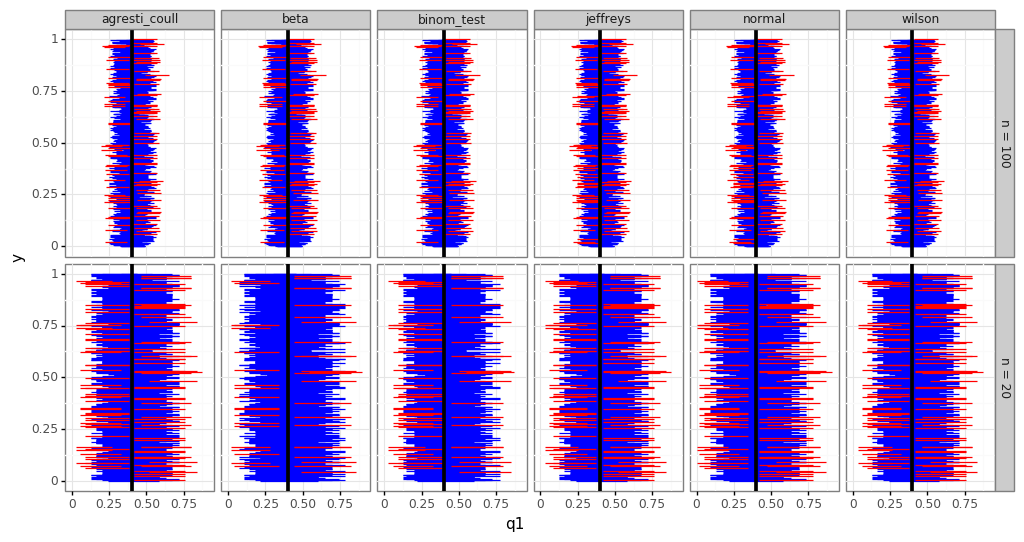

<ggplot: (-9223372029313740968)>

In [4]:
import warnings
warnings.filterwarnings('ignore')

def conf_locations_plot(gg_intervals):
    gg_intervals['n_label'] = gg_intervals.apply(lambda df: r'n = {}'.format(df['n']), axis = 1)
    
    gg = ggplot(gg_intervals, aes(x = 'q1', xend = 'q2', y = 'y', yend = 'y', colour = 'is_fail')) + \
        geom_segment() + \
        geom_vline(aes(xintercept = p), size = 1.5) + \
        facet_grid(['n_label', 'method']) + \
        scale_color_manual(guide = False, values = ['blue', 'red']) + \
        theme_bw() + \
        theme(figure_size = (12, 6))
    display(gg)

gg_intervals_01 = intervals[intervals.alpha == 0.1].assign(p = p)
conf_locations_plot(gg_intervals_01)

**And also for $\alpha = 0.01$.**

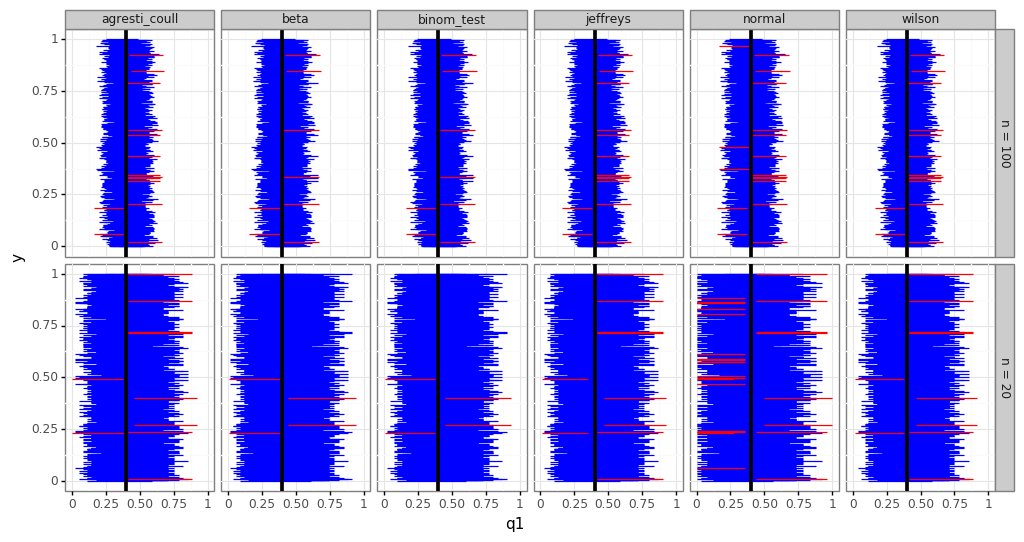

<ggplot: (7543571008)>

In [5]:
gg_intervals_001 = intervals[intervals.alpha == 0.01].assign(p = p)
conf_locations_plot(gg_intervals_001)

**We can easily see that the confidence intervals are smaller for bigger $n$.**

**Further, compare the $\alpha = 0.1$ figure above with the $\alpha = 0.01$ figure below. Note that we can control the length of the confidence intervals with the significance level $\alpha$, shortening the intervals and effectively increasing the number of mistakes by relaxing $\alpha$.**

**We can also confirm that for $n = 20$ and $\alpha = 0.01$ in particular, the beta method (but also the binomial test) seems to make fewer mistakes in average than other methods.**

## 1.2 Confidence intervals and engineering tradeoffs* (<font color='red'>2p</font>)

In practise, one often needs to find a right trade-off between the length of the interval and the expected fraction of failures where the true value is outside the interval. Consider the following two-stage measurement scheme. You can first do low-precision measurements to determine the approximate value of $y_0$ and later use high precision measurement device to get the final measurement value. Each low precision measurement costs $0.05$ € and the high precision measurement costs proportionally to the length of the initial interval estimate. A high-precision scan through a unit length interval costs 1 €. 

Describe at least two possible measurement strategies and use simulation to estimate their efficiency, i.e., the average amount of money needed to get a successful high-precision measurement.
During the simulation assume that the true paramater value $y_0=0.5$ and low quality measurements come from a normal distribution `numpy.random.normal(loc=y_0, scale=0.2)` 

As you get sample from the normal distribution, you need to a confidence intervals for estimating the mean value of a normal distribution samples without knowing the variance. The corresponding method is implemented as [`statsmodels.stats.weightstats.zconfint`](https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.zconfint.html#statsmodels.stats.weightstats.zconfint) 





## Solution

**We saw above that we can control the length of the confidence intervals with the sample size $n$ and confidence level $1 - \alpha$. Here, we assume that increasing the sample size by 1 costs $0.05 €$ and building a confidence interval of length $L$ costs $L €$. We assume that $y_i \sim N(y_0, \sigma = 0.2)$, $i = 1, ..., n$ and that $y_0 = 0.5$.**

**We are trying to find the most cost effective strategy for determining the true parameter $y_0$ by considering the following strategies: perform $i \in [2, 10]$ low-precision measurements (sample from the distribution), followed by a high-precision scan (build the confidence interval) with confidence $j \in \{ 0.99, 0.95, 0.9, 0.8, 0.5 \}$.**

In [6]:
def generate_data(n):
    return np.random.normal(loc = 0.5, scale = 0.2, size = n)

def cost_analysis(n, alpha, N_sims = 1000):
    cost = 0
    nr_success = 0
    
    for i in range(N_sims):
        vec = generate_data(n)
        interval = zconfint(vec, alpha = alpha) # norm.ppf([0.025, 0.975], loc = vec.mean(), scale = vec.std(ddof = 1)/np.sqrt(n_low))
        
        cost += 0.05*n + 1*(interval[1] - interval[0])
        nr_success += (0.5 <= interval[1]) & (0.5 >= interval[0])
    
    return cost / nr_success

strategies = DataFrame(index = np.arange(2, 11), columns = [0.01, 0.05, 0.1, 0.2, 0.5]) \
    .rename_axis(index = 'n', columns = "alpha")

for n, alpha in tqdm(itertools.product(strategies.index.values, strategies.columns.values), total = np.prod(strategies.shape)):
    strategies.loc[n, alpha] = cost_analysis(n, alpha)

display(strategies)

100%|██████████| 45/45 [00:10<00:00,  4.38it/s]


alpha,0.01,0.05,0.1,0.2,0.5
n,,,,,
2,0.899737,0.778696,0.699152,0.679694,0.679096
3,0.772294,0.69546,0.632624,0.612652,0.661432
4,0.72792,0.65451,0.630924,0.620573,0.708931
5,0.735592,0.666655,0.627646,0.643286,0.780586
6,0.736257,0.671264,0.658911,0.67409,0.851682
7,0.760882,0.704158,0.684177,0.735464,1.00564
8,0.780078,0.73018,0.72895,0.754488,1.04719
9,0.807211,0.769917,0.754097,0.809491,1.15085
10,0.838341,0.825529,0.808382,0.840571,1.16061


**Note that by increasing $n$ xor $\alpha$, the cost initially decreses but at some point starts to increase again.**

**In average (out of 1000 simulations), the most cost effective strategy among our set of all strategies to determine the true parameter $y_0$ value seems to be to first sample 3 times from the distribution and then build an $80\%$ confidence interval.**

## 1.3 Confidence intervals and multiple hypothesis testing (<font color='red'>1p</font>)

Confidence intervals are also impacted by the multiple hypothesis testing problem. Namely, the fraction of possible datasets where two or more confidence intervals hold simultaneously is significantly smaller than the fraction of datasets where one confidence interval holds. 

Assume that all intervals have the same confidence level $\alpha$ if we consider them separately. 
Let $F_i$ denote the event that the $i$th confidence interval is incorrect on data sample.
If we esitimate independent parameters, e.g room temperature and length of a person, the prbability that at least one confidence interval fails can be computed 

\begin{align*}
\Pr[F_1=0\wedge \ldots\wedge F_m=0] = \Pr[F_1=0]\cdots \Pr[F_m=0]=(1-\alpha)^m\lesssim 1-m\alpha 
\end{align*}

If these intervals are dependent, e.g. we estimate height and weight on the same time or recompute paremeter based on extended set of observations then we can use only union bound

\begin{align*}
\Pr[F_1=0\wedge\ldots\wedge F_m=0] &= 1- \Pr[F_1=1\vee\ldots\vee F_m=0]\\
  &\leq 1- \Pr[F_1=0]-\ldots-\Pr[F_m=0]=1-m\alpha\enspace. 
\end{align*}

These two bounds provide optimistic and pessimistic estimates on the confidence levels in standard settings, as it is much harder to reliably estimate the effect of correlations to approximation failures.


Study the difference between these estimates. Let the target confidence level be $95\%$. Compute what should be the confidence level for an individual interval if we consider $m=1,2,4, \ldots, 1024$ intervals based on the optimistic and pessimistic estimates. Draw a corresponding lineplot.

Verify whether these estimates hold in practice by using samples from a fair coin and compute the corresponding confidence interval for the proportion:
* For each run sample 1024 throws of an unbiased coin.
* Estimate $p$ form the first 256, 512, 1024 samples.
* You get three dependent confidence intervals
* Estimate the fraction of runs for which $0.5$ is inside of all intervals.
* Compare the result with the optimistic and pessimistic estimate.

Interpret results. How easy is to build meaningful confidence intervals for many parameters if they must hold simulataneusly.  

## Solution

**Conducting a statistical test with significance level $\alpha$ means that we can expect to reject the null hypothesis incorrectly with probability $\alpha$. However, if we conduct multiple independent tests, the probability to make a mistake increases. This is known as the multple testing problem.**

**Here, we wanted to control the significance level such that the probability to make a single mistake in a family of $m$ tests is $\alpha_f = 0.05$. The significance level $\alpha$ of individual tests according to the two strategies outlined above should then be as follows:**

**Optimistic strategy: $(1 - \alpha)^m = 1 - \alpha_f \iff \alpha = 1 - (1 - \alpha_f)^{1/m}$.**

**Pessimistic strategy (also known as the Bonferroni correction): $1 - m\alpha = 1 - \alpha_f \iff \alpha = \dfrac{\alpha_f}{m}$.**

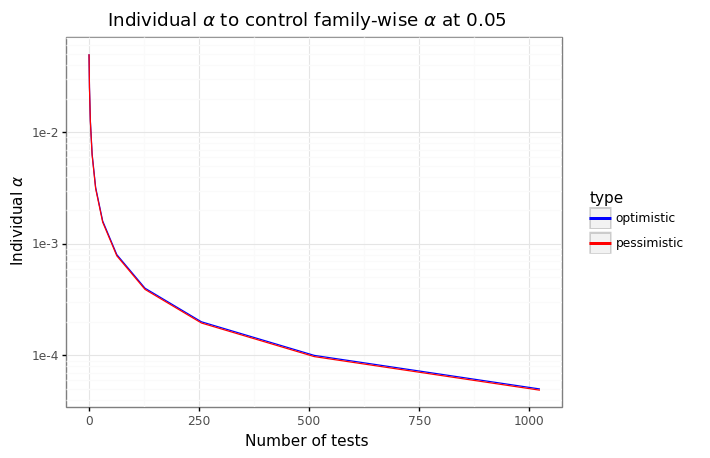

<ggplot: (7544465728)>

In [7]:
# Pessimistic: 1 - ma = 0.95; a = 0.05/m
def alpha_individual_pessimistic(alpha_family, m):    
    return alpha_family / m

# Optimistic: (1 - a)^m = 0.95; a = 1 - 0.95^(1/m)
def alpha_individual_optimistic(alpha_family, m):    
    return 1 - (1 - alpha_family)**(1/m)

m_values = [2**i for i in range(11)]
alpha_family = 0.05

alphas_pessimistic = [alpha_individual_pessimistic(alpha_family, m) for m in m_values]
alphas_optimistic = [alpha_individual_optimistic(alpha_family, m) for m in m_values]

dat = pd.concat([DataFrame({'alpha': alphas_optimistic, 'type': 'optimistic', 'm': m_values}),
                 DataFrame({'alpha': alphas_pessimistic, 'type': 'pessimistic', 'm': m_values})], ignore_index = True)
gg = ggplot(dat, aes(x = 'm', y = 'alpha', colour = 'type')) + \
    geom_line() + \
    theme_bw() + \
    scale_y_log10() + \
    xlab('Number of tests') + \
    ylab(r'Individual $\alpha$') + \
    ggtitle(r'Individual $\alpha$ to control family-wise $\alpha$ at 0.05') + \
    scale_colour_manual(values = ['blue', 'red'])
display(gg)

**We can see that the optimistic and pessimistic strategies for finding the significance level of $\alpha$ of individual tests do not differ by all that much.**

**Next, we simulated 1024 independent throws of an unbiased coin and estimated the fraction of heads/tails $p$ based on the first 256, 512 and 1024 throws. We did this 1000 times and estimated the fraction of runs for which the true parameter $p = 0.5$ was inside the confidence interval of all three estimates.**

In [8]:
def estimate_dependent(N_sims = 1000):
    N_in_intervals = 0
    
    for i in tnrange(N_sims):
        coin_throws = binom.rvs(n = 1, p = 0.5, size = 1024)
        CI_256 = proportion_confint(sum(coin_throws[:256]), nobs = 256, alpha = 0.05, method = 'binom_test')
        CI_512 = proportion_confint(sum(coin_throws[:512]), nobs = 512, alpha = 0.05, method = 'binom_test')
        CI_1024 = proportion_confint(sum(coin_throws), nobs = 1024, alpha = 0.05, method = 'binom_test')
        
        N_in_intervals += (0.5 >= max([CI_256[0], CI_512[0], CI_1024[0]])) & (0.5 <= min([CI_256[1], CI_512[1], CI_1024[1]]))
    
    return N_in_intervals / N_sims

print('Fraction of runs for which the true p was inside all intervals is {}.'.format(estimate_dependent()))
print('Confidence with the optimistic strategy is {}.'.format((1 - alpha_family)**3))
print('Confidence with the pessimistic strategy is {}.'.format(1 - 3*alpha_family))


Fraction of runs for which the true p was inside all intervals is 0.891.
Confidence with the optimistic strategy is 0.8573749999999999.
Confidence with the pessimistic strategy is 0.85.


**The optimistic and pessimistic confidence estimates are both too pessimistic (i.e. significance levels are too conservative). It is difficult to build confidence intervals for many dependent tests due to the unknown dependence structure.**